In [2]:
import re as re

import pandas as pd
import numpy as np

from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%ls data

Air pollutant.csv  Energy.csv         GWP.csv            sector.csv


In [4]:
airpolu=pd.read_csv("data/Air pollutant.csv")
energy=pd.read_csv("data/Energy.csv")
GWP=pd.read_csv("data/GWP.csv").iloc[:,:4]
sector=pd.read_csv("data/sector.csv")

In [5]:
def combineSector(df, df_sector):
    def find_number(text):
        num = re.findall(r'[0-9]+',text)
        return " ".join(num)

    def first2(text):
        return text[:2]
    df2 = df.copy()
    ID2 = df2['ID'].map(find_number).map(first2).astype('int64')
    df2.insert(loc=1, column='ID2', value=ID2)
    df_sector=df_sector.merge(df2, on='ID2', how='right')
    return df_sector

def tsneFind2Pinciple(df_sector):

    Principle = TSNE(n_components=2).fit_transform(df_sector.iloc[:,4:])
    Principle=pd.DataFrame(Principle, columns=['P1','P2'])
    new_df=df_sector.iloc[:,:4]
    new_df[['P1','P2']]=Principle
    return new_df

def addCluster(df_sector, df_principle):

    clustering = SpectralClustering(n_clusters=3, assign_labels='discretize',random_state=0).fit(df_principle[['P1','P2']])
    df_principle['cluster']=clustering.labels_
    return df_principle
    
def checkGroupAgg(df, df_sector_cluster, by=['cluster','Sector'], func = ['max','min']):
    df_cluster = pd.concat([df_sector_cluster[by], df.iloc[:,2:]], axis=1)
    return df_cluster.groupby(by).agg(func).style.highlight_max(axis=0)

def groupcount(df_sector_cluster):
    df = df_sector_cluster[['cluster','Sector','ID']].groupby(['cluster','Sector']).agg('count').reset_index(drop=False)
    df.columns=['cluster','Sector','count']
    return df.sort_values(by=['cluster','count'], ascending=False)

def masking0row(df):
    df_data=df.iloc[:,3:]
    mask = (df_data != 0).sum(1)!=0
    print('Drop', len(df[-mask]['Subsector']), 'unrelative subsectors that contain only zero \n',df[-mask]['Subsector'], )
    return df[mask]

def plot_scatter(df_sector_cluster, style="cluster", hue="cluster", size = None, figsize = (5,5), if_ledgend= True):
    plt.figure(figsize=figsize)
    g= sns.scatterplot(data=df_sector_cluster, x="P1", y="P2", style=style, hue=hue, size = size, palette="viridis")
    if if_ledgend:
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    else:
        plt.legend([],[], frameon=False)
    plt.show()
    
def plot_lm(df_sector_cluster, hue="cluster", figsize = (5,5), if_ledgend= True):
    plt.figure(figsize=figsize)
    g= sns.lmplot(data=df_sector_cluster, x="P1", y="P2", hue=hue, ci=None)
    if if_ledgend:
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    else:
        plt.legend([],[], frameon=False)
    plt.show()

def plotHeatmap(df):
    # Compute the correlation matrix
    corr = df.iloc[:,2:].corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

In [6]:
# df = airpolu.merge(GWP.drop(columns=['Total t CO2e']), on=['ID'], how='outer').fillna(0)
# df['Subsector_x']=df['Subsector_x'].astype('str') + " OR " + df['Subsector_y'].astype('str')
# df= df.drop(columns=['Subsector_y']).rename(columns={"Subsector_x": "Subsector"})
# df = df.merge(energy.drop(columns=['Total Energy TJ']), on=['ID'], how='outer').fillna(0)
# df['Subsector_x']=df['Subsector_x'].astype('str') + " OR " + df['Subsector_y'].astype('str')
# df= df.drop(columns=['Subsector_y']).rename(columns={"Subsector_x": "Subsector"})
# df.head(5)

In [10]:

df= GWP.drop(columns=['Total t CO2e'])
df = df.merge(energy.drop(columns=['Total Energy TJ']), on=['ID'], how='outer').fillna(0)
df['Subsector_x']=df['Subsector_x'].astype('str') + " OR " + df['Subsector_y'].astype('str')
df= df.drop(columns=['Subsector_y']).rename(columns={"Subsector_x": "Subsector"})
df

,ID,Subsector,CO2 t CO2e,Coal TJ,Nat Gas TJ,Petrol TJ,Bio/Waste TJ,NonFossElec TJ
0,1111B0,Grain farming OR Grain farming,6080000.0,0.0,10400.0,80500.0,0.0,14800.0
1,221100,Power generation and supply OR Power generatio...,25800000.0,232000.0,67900.0,11300.0,0.0,7450.0
2,1121A0,Cattle ranching and farming OR Cattle ranching...,1250000.0,0.0,1240.0,17300.0,0.0,3580.0
3,1111A0,Oilseed farming OR Oilseed farming,2150000.0,0.0,3810.0,28400.0,0.0,5610.0
4,311111,Dog and cat food manufacturing OR Dog and cat ...,8100000.0,7130.0,137000.0,8410.0,8120.0,42300.0
...,...,...,...,...,...,...,...,...
423,S00900,ROW Adjustment OR ROW Adjustment,0.0,0.0,0.0,0.0,0.0,0.0
424,813100,Religious organizations OR Religious organizat...,0.0,0.0,0.0,0.0,0.0,0.0
425,230201,Residential permanent site single- and multi-f...,0.0,0.0,0.0,0.0,0.0,0.0
426,S00401,Scrap OR Scrap,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
scaler = MinMaxScaler(feature_range=(0,10))
df.iloc[:,2:] =scaler.fit_transform(df.iloc[:,2:])
df = masking0row(df).reset_index(drop=True)
print(df.shape)

Drop 18 unrelative subsectors that contain only zero 
 410           Death care services OR Death care services
411    Elementary and secondary schools OR Elementary...
412    General Federal Defense OR General Federal Def...
413    General Federal non-defense government industr...
414    Home health care services OR Home health care ...
415         Hunting and trapping OR Hunting and trapping
416    Museums, historical sites, zoos, and parks OR ...
417       Noncomparable Imports OR Noncomparable Imports
418    Nonresidential commercial and health care stru...
419    Nonresidential manufacturing structures OR Non...
420    Other nonresidential structures OR Other nonre...
421    Owner-Occupied Dwellings OR Owner-Occupied Dwe...
422             Private households OR Private households
423                     ROW Adjustment OR ROW Adjustment
424    Religious organizations OR Religious organizat...
425    Residential permanent site single- and multi-f...
426                              

In [12]:
# sns.pairplot(df.iloc[:,2:])

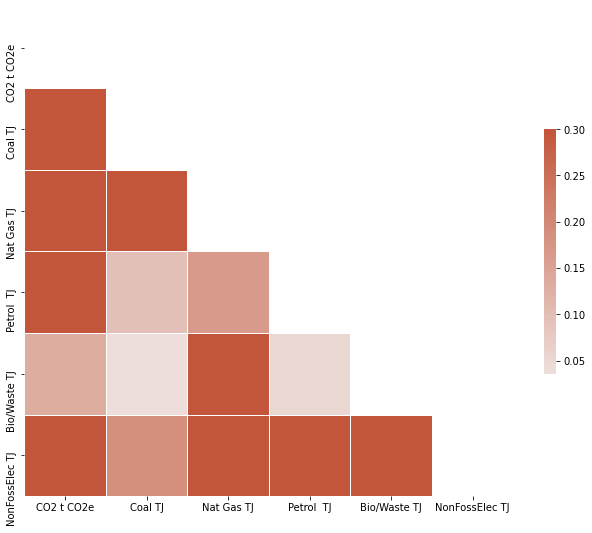

In [13]:
plotHeatmap(df)

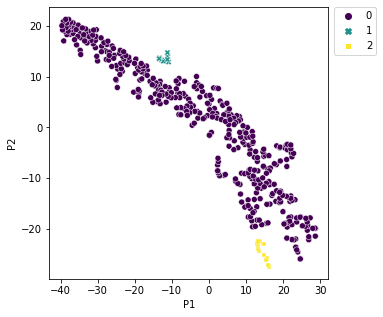

In [14]:
sector = combineSector(df, df_sector=sector)
principle = tsneFind2Pinciple(sector)
sector_cluster= addCluster(df_sector=sector, df_principle=principle)
plot_scatter(sector_cluster, style='cluster', hue='cluster', if_ledgend= True)

<Figure size 360x360 with 0 Axes>

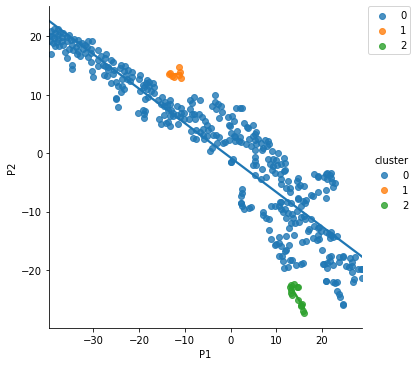

In [15]:
plot_lm(sector_cluster, hue="cluster", if_ledgend= True)

CO2 t CO2e


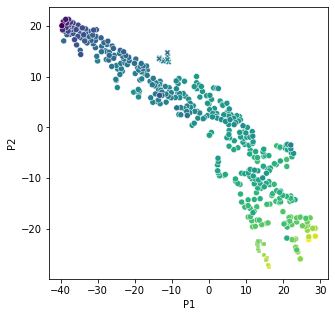

Coal TJ


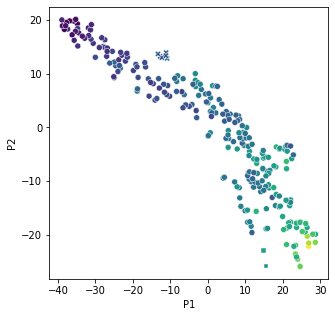

Nat Gas TJ


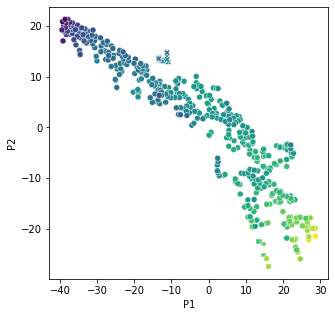

Petrol  TJ


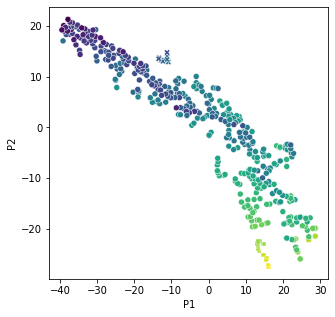

Bio/Waste TJ


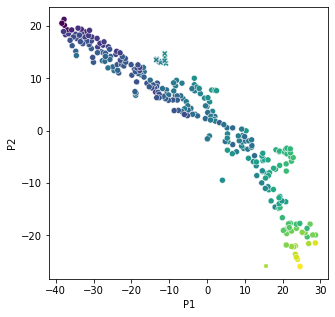

NonFossElec TJ


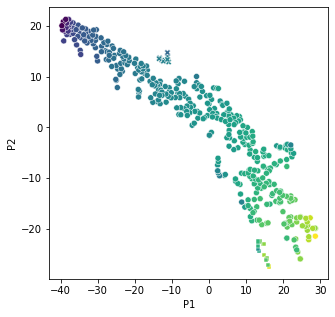

In [16]:
for col in df.columns[2:]:
    print(col)
    col0mask = df[col]!=0
    plot_scatter(sector_cluster[col0mask], hue=np.log(df[col][col0mask]), figsize = (5,5), if_ledgend = False) 

In [17]:
checkGroupAgg(df = energy, df_sector_cluster = sector_cluster,
             by=['cluster'], func = ['max','min'])

In [18]:
checkGroupAgg(df = energy, df_sector_cluster = sector_cluster,
             by=['cluster','Sector'], func = ['max','min'])

In [19]:
groupcount(sector_cluster)

,cluster,Sector,count
18,2,"Agriculture, Forestry, Fishing and Hunting",6
21,2,Transportation and Warehousing,5
19,2,Construction,1
20,2,Manufacturing,1
22,2,Wholesale Trade,1
17,1,Manufacturing,8
10,0,Manufacturing,270
8,0,Information,14
13,0,"Professional, Scientific, and Technical Services",14
2,0,"Agriculture, Forestry, Fishing and Hunting",12


In [26]:
sector_cluster.sort_values(by="cluster")[['Sector', 'Subsector', 'cluster']].to_csv('cluster_TSNE.csv')